In [1]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import pandas as pd
import numpy as np
import gensim
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier

2018-05-07 21:06:10,272 : INFO : 'pattern' package not found; tag filters are not available for English
/home/nikita/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
data = pd.read_csv('/home/nikita/PycharmProjects/natural_language/data/test_prepocess.csv')
data.head()

,stars,text,useful,funny
0,3,The good: mini doughnuts and americano friendl...,1,0
1,3,I really like the décor of the place and the w...,0,0
2,5,"Great service, clean and great food, this plac...",1,0
3,5,This place has never failed on me! \nLate nigh...,0,0
4,2,This is a fast food spin off from Paramount Fi...,1,1


In [16]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_batch = train_data[0:10000]
test_batch = test_data[0:5000]

In [4]:
def build_sentences_vector(sentence):
    words = sentence.split()
    result = np.zeros(100)
    size = 0
    for word in words:
        if word in embeding_model.wv.vocab:
            result+=embeding_model.wv[word]
            size+=1
    if size == 0:
        size = 1
    result /= size
    return result

In [5]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')
    
def plot_confusion_matrix(cm, title='Матрица ошибок', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    my_tags = pd.unique(data.stars)
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('Исходные метки')
    plt.xlabel('Полученные метки')

def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data.text)
    predictions = classifier.predict(data_features)
    target = data.stars
    evaluate_prediction(predictions, target)

In [6]:
embeding_model = Word2Vec.load('Yelp_embedings')
len(embeding_model.wv.vocab)

2018-05-07 21:06:24,837 : INFO : loading Word2Vec object from Yelp_embedings
2018-05-07 21:06:25,727 : INFO : loading wv recursively from Yelp_embedings.wv.* with mmap=None
2018-05-07 21:06:25,727 : INFO : setting ignored attribute vectors_norm to None
2018-05-07 21:06:25,729 : INFO : loading vocabulary recursively from Yelp_embedings.vocabulary.* with mmap=None
2018-05-07 21:06:25,729 : INFO : loading trainables recursively from Yelp_embedings.trainables.* with mmap=None
2018-05-07 21:06:25,730 : INFO : setting ignored attribute cum_table to None
2018-05-07 21:06:25,731 : INFO : loaded Yelp_embedings


101865

In [7]:
%%time
train_data_features = []
for sentense in train_batch.text:    
    train_data_features.append(build_sentences_vector(sentense))

CPU times: user 4 s, sys: 25.5 ms, total: 4.02 s
Wall time: 3.99 s


In [8]:
%%time
test_data_transform = []
for sentense in test_batch.text:
    test_data_transform.append(build_sentences_vector(sentense))

CPU times: user 1.94 s, sys: 0 ns, total: 1.94 s
Wall time: 1.93 s


In [9]:
%%time
knn_naive_dv = KNeighborsClassifier(n_neighbors=1, n_jobs=4, algorithm='brute', metric='cosine' )
knn_naive_dv.fit(train_data_features, train_batch.stars)
del train_batch
del test_batch
del embeding_model

CPU times: user 28.8 ms, sys: 8.05 ms, total: 36.9 ms
Wall time: 40.8 ms


In [10]:
%%time
predicted = knn_naive_dv.predict(test_data_transform)

CPU times: user 565 ms, sys: 885 ms, total: 1.45 s
Wall time: 2.64 s


accuracy 0.4566
confusion matrix
 [[ 354  129   81   65   65]
 [  93   82   89   84   56]
 [  75   80  167  203  100]
 [  62   69  171  478  360]
 [ 121   85  167  562 1202]]
(row=expected, col=predicted)


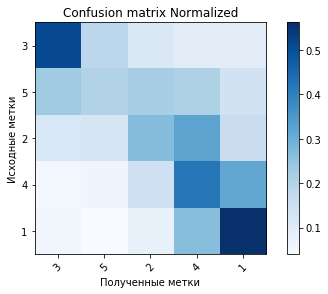

In [17]:
evaluate_prediction(predicted, test_batch.stars)